### Estimation of Shadow Rate Term Structure by Wu & Xia model

Disclaimer: The Wu&Xia model is an open-source model and available at: https://github.com/as4456/Wu_Xia

This notebook utilized the Wu&Xia model and provide a preliminary analysis on the sensitivity of parameters and robustness of the model. A more detailed investigation is available in python file in the package. This notebook is only served as illustration purpose.

In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import quandl
import os
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
import re


import numpy.matlib
from TAU_P import TAU_P
from EFK_SRTSM import EFK_SRTSM
from matplotlib.backends.backend_pdf import PdfPages
import datetime as dt

In [3]:
import os
import sys
#source ~/.bash_profile
%reload_ext dotenv
%dotenv

Python-dotenv could not parse statement starting at line 6


### The US Market

In [4]:
symbol = "USTREASURY/YIELD"  
df_T = web.DataReader(symbol, 'quandl', 
                               start='2006-01-01', 
                               end='2020-09-01')


df_T.drop(['2MO'],axis=1,inplace=True)
df_T.dropna(inplace=True)
df_T = df_T.sort_index(ascending=True)
display(df_T.head(), df_T.tail())

1MO   3MO   6MO   1YR   2YR   3YR   5YR   7YR  10YR  20YR  30YR
Date                                                                        
2006-02-09  4.32  4.52  4.67  4.66  4.66  4.62  4.55  4.55  4.54  4.72  4.51
2006-02-10  4.36  4.53  4.70  4.70  4.69  4.67  4.59  4.59  4.59  4.76  4.55
2006-02-13  4.38  4.55  4.71  4.70  4.68  4.66  4.58  4.58  4.58  4.76  4.56
2006-02-14  4.42  4.55  4.72  4.71  4.69  4.68  4.61  4.61  4.62  4.80  4.60
2006-02-15  4.39  4.55  4.70  4.70  4.71  4.68  4.60  4.60  4.61  4.78  4.58

1MO   3MO   6MO   1YR   2YR   3YR   5YR   7YR  10YR  20YR  30YR
Date                                                                        
2020-08-26  0.08  0.11  0.12  0.12  0.16  0.18  0.28  0.50  0.69  1.20  1.41
2020-08-27  0.09  0.11  0.11  0.13  0.16  0.19  0.31  0.53  0.74  1.28  1.50
2020-08-28  0.09  0.10  0.11  0.12  0.14  0.16  0.28  0.51  0.74  1.29  1.52
2020-08-31  0.08  0.11  0.13  0.12  0.14  0.15  0.28  0.50  0.72  1.26  1.49
2020-09-01  0.09  0.12  0.13  0.12  0.13  0.14  0.26  0.46  0.68  1.20  1.43

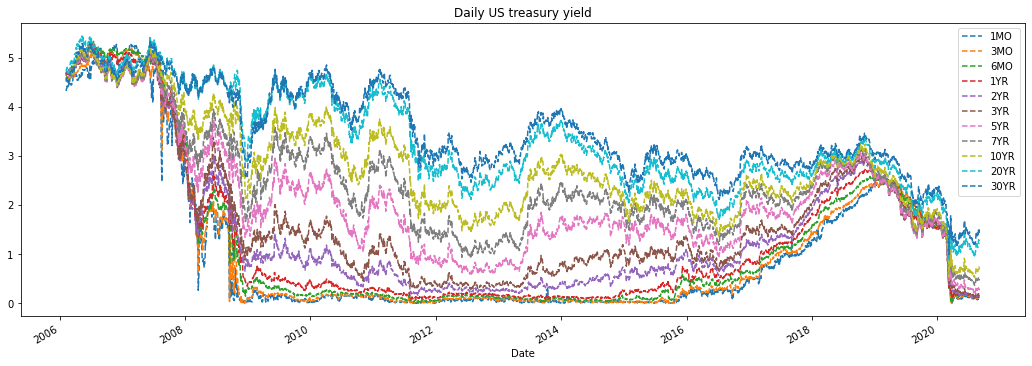

In [15]:
df_T.plot(figsize = (18,6),ls='--')
plt.title('Daily US treasury yield')
plt.show()

In [6]:
# convert into monthly data (use the first observation)
df_T["month"] = [dt.datetime.strftime(x,"%Y%m") for x in df_T.index]
df_M = df_T.groupby("month").mean()

In [7]:
display(df_M.head(), df_M.tail())

1MO       3MO       6MO       1YR       2YR       3YR       5YR  \
month                                                                          
200602  4.410769  4.565385  4.713077  4.708462  4.696923  4.672308  4.597692   
200603  4.549565  4.627826  4.792174  4.773478  4.733913  4.738261  4.716087   
200604  4.605263  4.721579  4.900000  4.897368  4.888947  4.885263  4.902105   
200605  4.699545  4.836364  5.010000  4.995000  4.968182  4.974545  4.997727   
200606  4.710455  4.917727  5.172727  5.155000  5.121818  5.088182  5.067273   

             7YR      10YR      20YR      30YR  
month                                           
200602  4.580769  4.573077  4.734615  4.536923  
200603  4.713913  4.723913  4.913478  4.734348  
200604  4.935263  4.990526  5.224211  5.062632  
200605  5.032273  5.110000  5.346364  5.201364  
200606  5.075455  5.106364  5.292273  5.154091

1MO       3MO       6MO       1YR       2YR       3YR       5YR  \
month                                                                          
202005  0.098500  0.127500  0.153500  0.161500  0.170500  0.218000  0.339500   
202006  0.130000  0.159545  0.180000  0.176364  0.185000  0.224545  0.344545   
202007  0.105909  0.126818  0.141364  0.145455  0.148182  0.173636  0.278636   
202008  0.082381  0.104286  0.119524  0.130476  0.139524  0.161429  0.266667   
202009  0.090000  0.120000  0.130000  0.120000  0.130000  0.140000  0.260000   

             7YR      10YR      20YR      30YR  
month                                           
202005  0.525000  0.674000  1.124500  1.378000  
202006  0.554545  0.728636  1.266364  1.493636  
202007  0.462273  0.623636  1.091818  1.310455  
202008  0.462857  0.650000  1.135238  1.358095  
202009  0.460000  0.680000  1.200000  1.430000

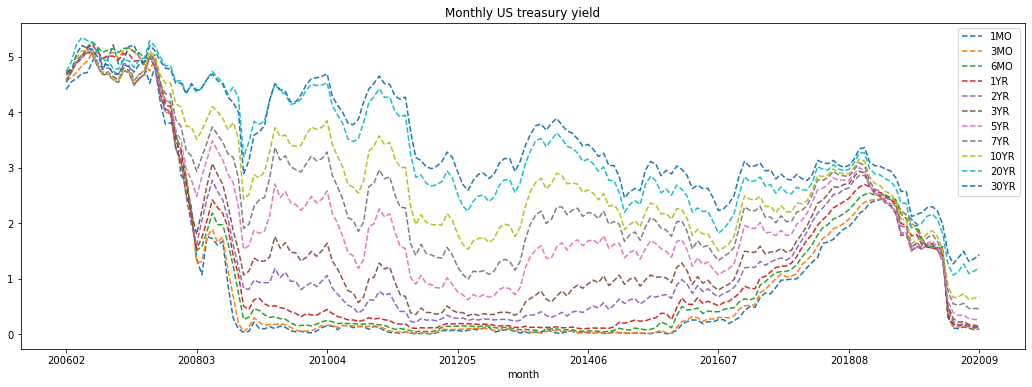

In [14]:
df_M.plot(figsize = (18,6),ls='--')
plt.title('Monthly US treasury yield')
plt.show()

In [9]:
maturities = np.array([1, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360])/12
maturities_diff = np.diff(maturities)
T,n = df_M.shape

In [10]:
forward_rate = df_M.values[:,:-1]  + (maturities[1:] * (np.diff(df_M,axis=1)/maturities_diff))
forward_rate = np.c_[df_M.values[:,0],forward_rate]

In [11]:
cols = ["f"+str(maturities[i])+","+str(maturities[i+1]) for i in range(n-1)]
cols.insert(0,'f0,1/12')
forward_df = pd.DataFrame(forward_rate,columns=cols,index=df_M.index)

In [12]:
forward_df_plot = forward_df.copy()
forward_df_plot.columns = df_M.columns

1MO       3MO       6MO       1YR       2YR       3YR       5YR  \
month                                                                          
200602  4.410769  4.642692  4.860769  4.703846  4.685385  4.623077  4.485769   
200603  4.549565  4.666957  4.956522  4.754783  4.694348  4.746957  4.682826   
200604  4.605263  4.779737  5.078421  4.894737  4.880526  4.877895  4.927368   
200605  4.699545  4.904773  5.183636  4.980000  4.941364  4.987273  5.032500   
200606  4.710455  5.021364  5.427727  5.137273  5.088636  5.020909  5.035909   
...          ...       ...       ...       ...       ...       ...       ...   
202005  0.098500  0.142000  0.179500  0.169500  0.179500  0.313000  0.521750   
202006  0.130000  0.174318  0.200455  0.172727  0.193636  0.303636  0.524545   
202007  0.105909  0.137273  0.155909  0.149545  0.150909  0.224545  0.436136   
202008  0.082381  0.115238  0.134762  0.141429  0.148571  0.205238  0.424524   
202009  0.090000  0.135000  0.140000  0.110000  0.140000  0.160000  0.440000   

             7YR      10YR      20YR      30YR  
month                                           
200602  4.538462  4.555128  4.896154  4.141538  
200603  4.708478  4.747246  5.103043  4.376087  
200604  5.018158  5.119474  5.457895  4.739474  
200605  5.118636  5.291364  5.582727  4.911364  
200606  5.095909  5.178485  5.478182  4.877727  
...          ...       ...       ...       ...  
202005  0.988750  1.021667  1.575000  1.885000  
202006  1.079545  1.134848  1.804091  1.948182  
202007  0.921364  1.000152  1.560000  1.747727  
202008  0.953333  1.086667  1.620476  1.803810  
202009  0.960000  1.193333  1.720000  1.890000  

[176 rows x 11 columns]

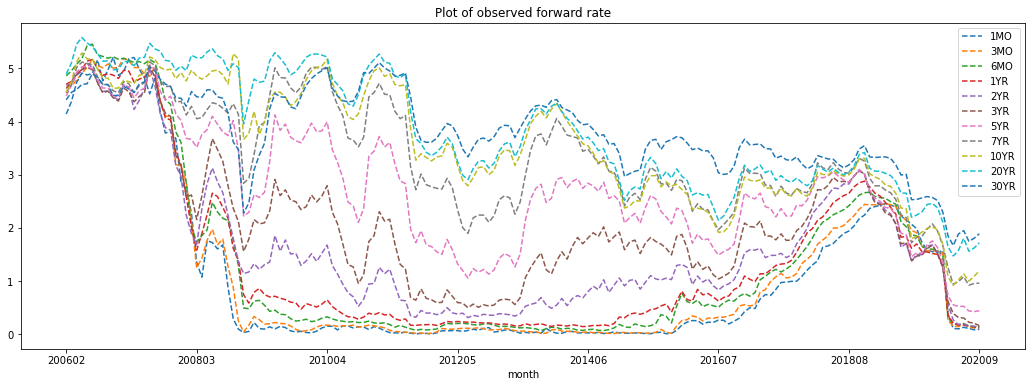

In [13]:
forward_df_plot.plot(figsize = (18,6),ls='--')
plt.title('Plot of observed forward rate')
plt.show()

### Calibrate the model parameters

Shadow Rate -Black(1995) 

$$ r_t = max(\underline{r}, s_t)   \tag{1}$$

$$ s_t = \delta_0 + \delta_1^{'} X_t  \tag{2} $$

VAR(1) under the neutral measure

$$ X_{t+1} = \mu + \rho X_t + \Sigma \epsilon_{t+1}, \epsilon \sim N(0,I) \tag{3} $$ 

VAR(1) under the physical measure

$$ X_{t+1} = \mu^Q + \rho^Q X_t + \Sigma \epsilon_{t+1}^Q, \epsilon_{t+1}^Q \sim N(0,I) \tag{4}$$

The parameters in P and Q measures are related as:

$$ \mu - \mu^Q = \Sigma \lambda_0 \tag{5}$$

$$ \rho - \rho^Q = \Sigma \lambda_1 \tag{6}$$

$\lambda_0, \lambda_1 $ is the price of risk

### Estimation
$$ f_{n,n+1,t} ^{SRTSM} = \underline{r} + \sigma_n^Q g\left( \frac{a_n + b_n^{'} X_t - \underline{r}}{\sigma_n^Q}\right)  \tag{7}$$


$$ f_{n,n+1,t} ^{O} = \underline{r} + \sigma_n^Q g\left( \frac{a_n + b_n^{'} X_t - \underline{r}}{\sigma_n^Q}\right) + \eta_{nt}  \tag{8}$$

$ g(z) := z \Phi (z) + \phi (z) $; $ (\sigma_n^Q)^2 = Var^Q(s_{t+n})$; $\eta_{nt} \sim N(0,\omega) $

Parameters to be estimated:

$$ \mu, \mu^Q, \rho, \rho^Q, \Sigma, \delta_0, \delta_1 $$

Statistical restrictions:

$\delta_1 = [1,1,0], \mu_Q = 0, \rho^Q = \begin{bmatrix}
   \rho_1 ^Q & 0 & 0 \\
     0 & \rho_2^Q & 1 \\
     0 &  0 & \rho_2^Q
   \end{bmatrix}$

#### Extended Kalman Filter for the SRTSM

$$ F_{t_1}^O = G(X_{t+1}) + \eta_{t+1}, \eta_{t+1} \sim N(0,\omega I_\tau ) $$

In [21]:
parameters = pd.read_excel("US_25.xlsx").iloc[:,1].values
maturities = np.array([0, 1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
maturities = np.array(maturities[1:])*12
maturities = np.array(maturities, dtype=int)
forwardrates = forward_df.values
dateList = forward_df.index
dateList = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in dateList]
parameters_df = pd.DataFrame(parameters)
parameters_df.columns= ['zlb_25']

### Calculate shadow rate

In [22]:
def parse_param (parameters,lower_bound):
    rhoP = parameters[0:9];
    rhoP = np.reshape(rhoP, [3,3], order='F')
    muP = parameters[9:12]
    rhoQ1 = parameters[12]; rhoQ2 = parameters[13];
    rhoQ = np.zeros((3, 3)); np.fill_diagonal(rhoQ, [rhoQ1, rhoQ2, rhoQ2])
    rhoQ[1, 2] = 1
    sigma = [[abs(parameters[14]), 0, 0],
            [parameters[15], abs(parameters[17]), 0],
            [parameters[16], parameters[18], abs(parameters[19])]]
    delta0 = parameters[20]
    sqrt_omega = parameters[21]
    nparam = np.append(parameters, lower_bound) # lower-bound
    return nparam

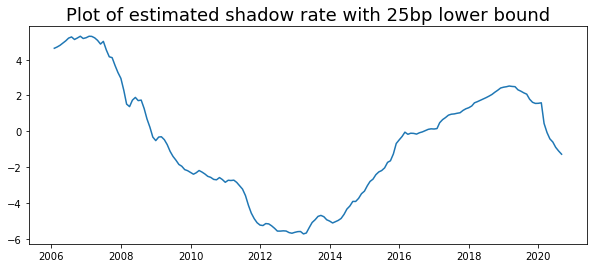

In [23]:
nparam = parse_param(parameters, 0.25)
SR = EFK_SRTSM(nparam,maturities,forwardrates,1)

plt.figure(figsize=(10,4))
plt.plot(dateList, SR)
plt.title('Plot of estimated shadow rate with 25bp lower bound', fontsize = 18)
plt.show()

### compare observed and fitted forward rates

In [24]:
Fit_forward = EFK_SRTSM(nparam,maturities,forwardrates,3).T

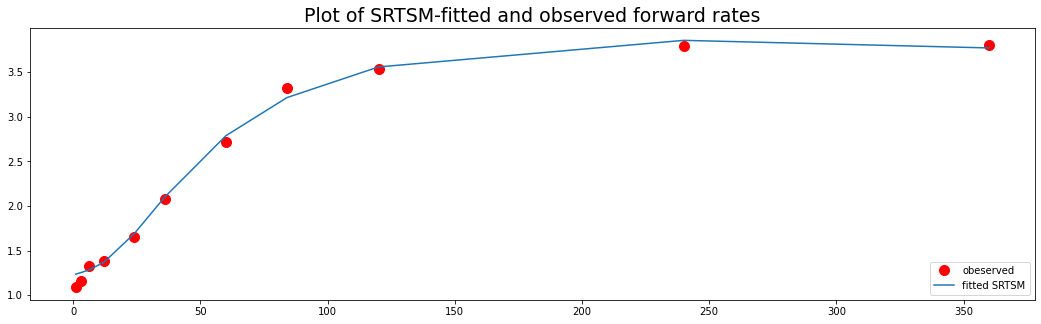

In [25]:
plt.figure(figsize= (18,5))
plt.plot(maturities, np.mean(forward_df, axis = 0), 'ro', ms= 10,label = 'obeserved')
plt.plot(maturities, np.mean(Fit_forward,axis = 0),label='fitted SRTSM')
plt.legend(loc=4)
plt.title('Plot of SRTSM-fitted and observed forward rates',fontsize=19)
plt.show()

### compute the shadow rate and compare it with the effective fed funds rate

In [28]:
symbol = "FRED/FEDFUNDS"  
df_fed = web.DataReader(symbol, 'quandl', 
                               start='2006-01-02', 
                               end='2020-09-01')

In [29]:
dateList = forward_df.index
dateList = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in dateList]

In [30]:
df_SR = pd.DataFrame(SR,index = dateList )

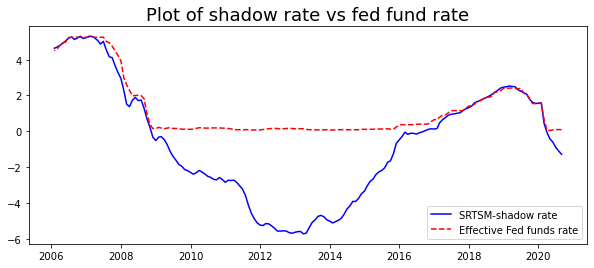

In [31]:
plt.figure(figsize=(10,4))
plt.plot(df_SR,'b',label = 'SRTSM-shadow rate')
plt.plot(df_fed,'r--', label = 'Effective Fed funds rate')
plt.title('Plot of shadow rate vs fed fund rate', fontsize= 18)
plt.legend(loc=4)
plt.show()

### Test ZLB sensitivity

We compare the lower bound equal to 0, 0.19% and 0.25% and see whether the estimated shadow rate diverges from each other.

In [32]:
parameters_25 = pd.read_excel("US_25.xlsx").iloc[:,1].values
parameters_19 = pd.read_excel("US_19.xlsx").iloc[:,1].values
parameters_00 = pd.read_excel("US_00.xlsx").iloc[:,1].values
parameters_25_df = pd.DataFrame(parameters_25)
parameters_19_df = pd.DataFrame(parameters_19)
parameters_00_df = pd.DataFrame(parameters_00)
parameters_25_df.columns = ['zlb_25']
parameters_19_df.columns= ['zlb_19']
parameters_00_df.columns = ['zlb_00']
param_merge = pd.concat((parameters_25_df,parameters_19_df,parameters_00_df),axis=1)
param_merge

zlb_25    zlb_19    zlb_00
0   1.016255  1.001654  1.007368
1  -0.031351  0.011816 -0.015792
2  -0.000701 -0.001403 -0.000391
3   0.007483  0.001867  0.009860
4   0.974960  0.981279  0.962226
5  -0.000253 -0.000621 -0.000458
6  -0.391110 -0.338409 -0.185854
7   2.579875  3.063136  1.398504
8   0.946673  0.947981  0.969490
9   0.069243 -0.028482  0.018313
10 -0.204369  0.056763 -0.124135
11 -0.005898 -0.010374 -0.004652
12  0.998646  0.998602  0.998839
13  0.968682  0.969080  0.962776
14 -0.224359 -0.219009 -0.202823
15 -0.155274 -0.161994 -0.194202
16  0.002182  0.001508  0.000636
17  0.325464  0.284263  0.457072
18 -0.008149 -0.000945 -0.013274
19 -0.015924 -0.014174 -0.017052
20  8.202138  7.725596  8.004291
21  0.179222  0.173602  0.170572

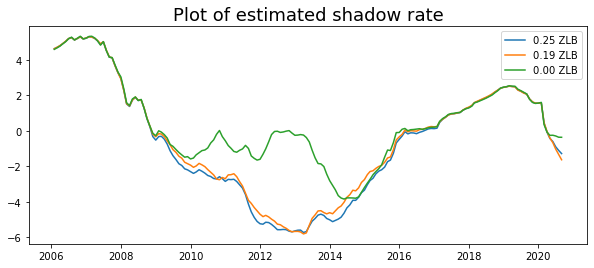

In [33]:
nparam_19 = parse_param(parameters_19, 0.19)
nparam_00 = parse_param(parameters_00, 0)
SR_19 = EFK_SRTSM(nparam_19,maturities,forwardrates,1)
SR_00 = EFK_SRTSM(nparam_00,maturities,forwardrates,1)

plt.figure(figsize=(10,4))
plt.plot(dateList, SR, label = '0.25 ZLB')
plt.plot(dateList, SR_19, label = '0.19 ZLB')
plt.plot(dateList, SR_00, label = '0.00 ZLB')
plt.title('Plot of estimated shadow rate', fontsize = 18)
plt.legend()
plt.show()

The model is senstivie to the ZLB in unconventional period. 0ZLB and 0.25ZLB provides very different results. However, the fitted shadow rates do not diverge significantly in conventional period, i.e. before 2009 and after 2014.

## Shadow rate and economic indicators

In [34]:
CPI = pd.read_excel('BBG\CPIYOYIndex.xlsx',skiprows = 5,index_col=0, parse_dates=True)
CPI['FIRST_REVISION'].fillna(CPI['PX_LAST'],inplace=True)
CPI.drop('PX_LAST',axis=1,inplace=True)
CPI.columns = ['CPI']

In [35]:
EFFR = pd.read_excel('BBG\EFFR.xlsx',skiprows = 10, index_col = 0 ,usecols = [0,1], parse_dates= True)
EFFR.columns = ['Effective fed fund rate']
EFFR

Effective fed fund rate
Field                             
2020-11-30                      --
2020-11-29                      --
2020-11-28                      --
2020-11-27                      --
2020-11-26                      --
...                            ...
2007-03-29                    5.29
2007-03-28                    5.27
2007-03-27                    5.25
2007-03-26                    5.28
2007-03-25                      --

[5000 rows x 1 columns]

In [36]:
USURTOT = pd.read_excel('BBG//USURTOT.xlsx',skiprows = 5,index_col = 0 ,parse_dates = True)
USURTOT['FIRST_REVISION'].fillna(USURTOT['PX_LAST'],inplace=True)
USURTOT.drop('PX_LAST',axis=1,inplace=True)
USURTOT.columns=['Unemployment']

In [37]:
QE = pd.read_excel('BBG\QE.xlsx',skiprows=8)
QE.drop([0,1,2,3,4,5],inplace=True,index=None)
QE_col = QE.columns.to_list()
QE_col[0] = 'Date'
QE.columns = QE_col
QE.reset_index(drop=True,inplace=True)
QE = QE.replace("--","")

In [38]:
mm = QE['Date'].apply(lambda x:x.split()[1])
yy = QE['Date'].apply(lambda x:x.split()[2].replace("'",""))
separator = '/20'
date=[]
for i in range(len(mm)):
    date.append(separator.join([mm[i],yy[i]]))

In [39]:
QE.Date = date
QE.set_index("Date",inplace=True)

In [40]:
df_QE = QE.copy()
df_QE.index = [dt.datetime.strptime(x,"%m/%d/%Y") for x in df_QE.index]
df_QE_mm = df_QE.groupby(pd.Grouper(freq='M')).last()
df_QE_mm = df_QE_mm[df_QE_mm.iloc[:,0]!=""]

In [41]:
symbol_gd = "FRED/GDP"  
df_GDP = web.DataReader(symbol_gd, 'quandl', 
                               start='2006-01-01', 
                               end='2020-10-01')

In [42]:
df_GDP.index = df_GDP.index.to_period('M').to_timestamp('M')
df_GDP.columns = ['GDP']

In [43]:
df_SR.index = dateList
df_SR.index = df_SR.index.to_period('M').to_timestamp('M')
df_SR.columns = ['SR_25']

In [44]:
factor_df = pd.concat([df_SR,df_GDP,CPI,USURTOT,df_QE_mm],axis=1,join='inner')
factor_df = factor_df.iloc[:,:5]
factor_df.head()

SR_25        GDP  CPI  Unemployment  \
2006-04-30  4.797962  13749.806  3.5           4.7   
2006-07-31  5.203065  13867.469  4.1           4.7   
2006-10-31  5.209284  14037.228  1.3           4.4   
2007-01-31  5.224445  14208.569  2.1           4.6   
2007-04-30  5.216507  14382.363  2.6           4.5   

           Total Factors Supplying Reserve Funds (USD, Millions)  
2006-04-30                                             875450     
2006-07-31                                             874020     
2006-10-31                                             885665     
2007-01-31                                             884757     
2007-04-30                                             912411

### Standarize the data into the same scale

In [45]:
factor_df['GDP'] = factor_df['GDP']/10000
factor_df['Total Factors Supplying Reserve Funds (USD, Millions)'] = factor_df['Total Factors Supplying Reserve Funds (USD, Millions)']/1000000
col_name = factor_df.columns.to_list()
col_name[-1] = 'Total_Reserve_Fund_Trillion'
factor_df.columns = col_name
factor_df = factor_df.astype(float)
factor_df.head()

SR_25       GDP  CPI  Unemployment  Total_Reserve_Fund_Trillion
2006-04-30  4.797962  1.374981  3.5           4.7                     0.875450
2006-07-31  5.203065  1.386747  4.1           4.7                     0.874020
2006-10-31  5.209284  1.403723  1.3           4.4                     0.885665
2007-01-31  5.224445  1.420857  2.1           4.6                     0.884757
2007-04-30  5.216507  1.438236  2.6           4.5                     0.912411

In [46]:
df_fed.index = df_fed.index.to_period('M').to_timestamp('M')
factor_df_plot = factor_df.copy()
factor_df_plot = factor_df_plot.merge(df_fed,right_index=True,left_index=True)

In [47]:
factor_df_plot.head()

SR_25       GDP  CPI  Unemployment  \
2006-04-30  4.797962  1.374981  3.5           4.7   
2006-07-31  5.203065  1.386747  4.1           4.7   
2006-10-31  5.209284  1.403723  1.3           4.4   
2007-01-31  5.224445  1.420857  2.1           4.6   
2007-04-30  5.216507  1.438236  2.6           4.5   

            Total_Reserve_Fund_Trillion  Value  
2006-04-30                     0.875450   4.79  
2006-07-31                     0.874020   5.24  
2006-10-31                     0.885665   5.25  
2007-01-31                     0.884757   5.25  
2007-04-30                     0.912411   5.25

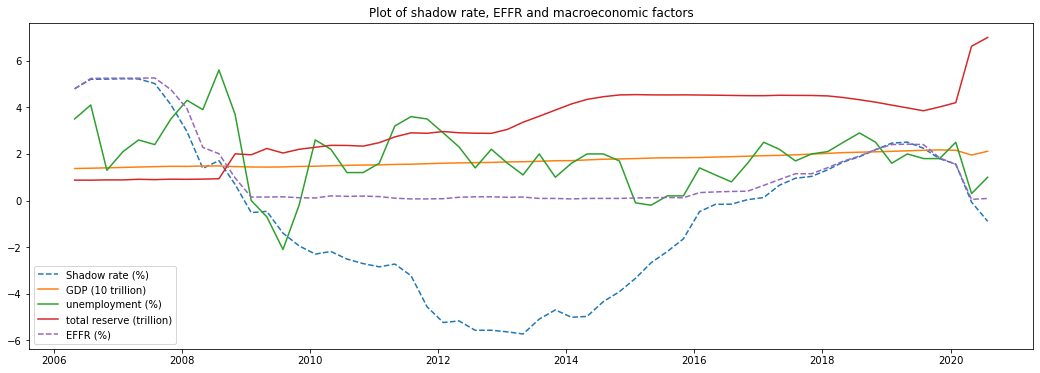

In [48]:
plt.figure(figsize = (18,6))
plt.plot(factor_df_plot['SR_25'], '--',label = 'Shadow rate (%)')
plt.plot(factor_df_plot['GDP'], label = 'GDP (10 trillion)')
plt.plot(factor_df_plot['CPI'], label = 'unemployment (%)')
plt.plot(factor_df_plot['Total_Reserve_Fund_Trillion'], label = 'total reserve (trillion)')
plt.plot(factor_df_plot['Value'], '--',label = 'EFFR (%)')
plt.legend()
plt.title('Plot of shadow rate, EFFR and macroeconomic factors')
plt.show()

### Test stationarity for level

In [49]:
for col in factor_df.columns:
    print(col)

    result = adfuller(factor_df[col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

SR_25
ADF Statistic: -2.886170
p-value: 0.046980
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596
GDP
ADF Statistic: -0.303066
p-value: 0.925069
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
CPI
ADF Statistic: -3.246862
p-value: 0.017427
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
Unemployment
ADF Statistic: -1.431939
p-value: 0.566872
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Total_Reserve_Fund_Trillion
ADF Statistic: -0.296649
p-value: 0.925978
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596


### Test stationarity for difference

In [50]:
for col in factor_df.columns:
    print(col)

    result = adfuller(factor_df[col].diff().dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

SR_25
ADF Statistic: -1.593366
p-value: 0.486925
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596
GDP
ADF Statistic: -9.328262
p-value: 0.000000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
CPI
ADF Statistic: -4.197575
p-value: 0.000665
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Unemployment
ADF Statistic: -9.842804
p-value: 0.000000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Total_Reserve_Fund_Trillion
ADF Statistic: -2.361352
p-value: 0.152943
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


### factor_model_1
### Shadow rate: Level
### Factor: Level

In [51]:
factor_model_1 = factor_df.copy()
X = sm.add_constant(factor_model_1.iloc[:,1:])
result = sm.OLS(factor_model_1['SR_25'],X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  SR_25   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     12.83
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.26e-07
Time:                        15:33:05   Log-Likelihood:                -131.24
No. Observations:                  58   AIC:                             272.5
Df Residuals:                      53   BIC:                             282.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [52]:
model = VAR(factor_model_1)
model.select_order(5)
results = model.fit(maxlags=5, ic='bic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Nov, 2020
Time:                     15:33:06
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -11.8343
Nobs:                     57.0000    HQIC:                  -12.4917
Log likelihood:          -6.47538    FPE:                2.48402e-06
AIC:                     -12.9095    Det(Omega_mle):     1.50600e-06
--------------------------------------------------------------------
Results for equation SR_25
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  3.491664         1.078979            3.236           0.001
L1.SR_25                               0.951606         0.027950           34.047         

In [53]:
pd.DataFrame(results.resid_corr,columns = col_name, index = col_name)

SR_25       GDP       CPI  Unemployment  \
SR_25                        1.000000  0.471833  0.310728     -0.455030   
GDP                          0.471833  1.000000  0.399347     -0.940507   
CPI                          0.310728  0.399347  1.000000     -0.395573   
Unemployment                -0.455030 -0.940507 -0.395573      1.000000   
Total_Reserve_Fund_Trillion -0.391223 -0.807302 -0.252709      0.825295   

                             Total_Reserve_Fund_Trillion  
SR_25                                          -0.391223  
GDP                                            -0.807302  
CPI                                            -0.252709  
Unemployment                                    0.825295  
Total_Reserve_Fund_Trillion                     1.000000

### Null hypothesis is that there is no Granger-causality for the indicated variables.

In [55]:
print('shadow rate -> GDP')
display(results.test_causality('GDP', ['SR_25'], kind='wald').summary())
print('shadow rate -> CPI')
display(results.test_causality('CPI', ['SR_25'], kind='wald').summary())
print('shadow rate -> Unemployment')
display(results.test_causality('Unemployment',['SR_25'], kind='wald').summary())
print('shadow rate -> QE')
display(results.test_causality('Total_Reserve_Fund_Trillion',['SR_25'], kind='wald').summary())

shadow rate -> GDP


<class 'statsmodels.iolib.table.SimpleTable'>

shadow rate -> CPI


<class 'statsmodels.iolib.table.SimpleTable'>

shadow rate -> Unemployment


<class 'statsmodels.iolib.table.SimpleTable'>

shadow rate -> QE


<class 'statsmodels.iolib.table.SimpleTable'>

In [56]:
print('GDP -> shadow rate')
display(results.test_causality('SR_25', ['GDP'], kind='wald').summary())
print('CPI -> shadow rate ')
display(results.test_causality('SR_25', ['CPI'], kind='wald').summary())
print('Unemployment -> shadow rate')
display(results.test_causality('SR_25',['Unemployment'], kind='wald').summary())
print('QE -> shadow rate')
display(results.test_causality('SR_25',['Total_Reserve_Fund_Trillion'], kind='wald').summary())

GDP -> shadow rate


<class 'statsmodels.iolib.table.SimpleTable'>

CPI -> shadow rate 


<class 'statsmodels.iolib.table.SimpleTable'>

Unemployment -> shadow rate


<class 'statsmodels.iolib.table.SimpleTable'>

QE -> shadow rate


<class 'statsmodels.iolib.table.SimpleTable'>

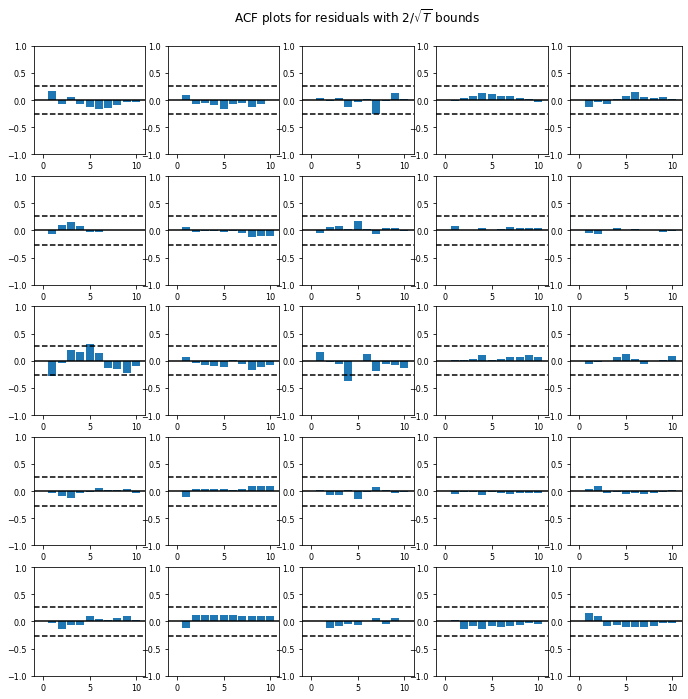

In [123]:
ACF_plot = results.plot_acorr()

In [59]:
lag_order = results.k_ar
print(lag_order)

1


<Figure size 1296x360 with 0 Axes>

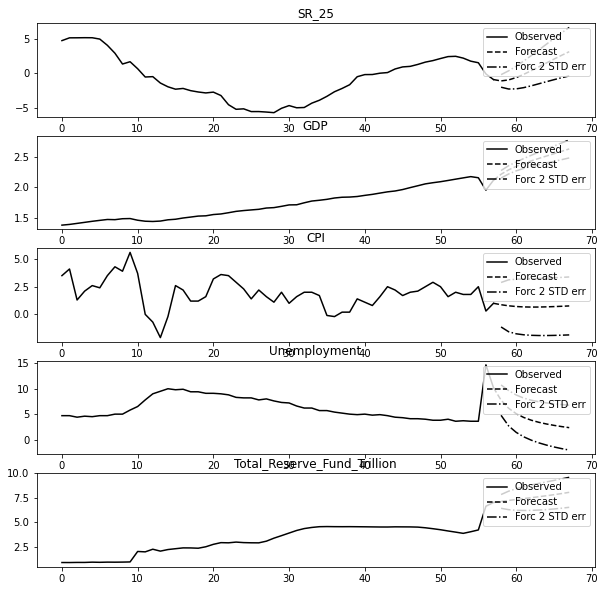

In [60]:
plt.figure(figsize=(18,5))
forcast_plot = results.plot_forecast(10)
plt.show()

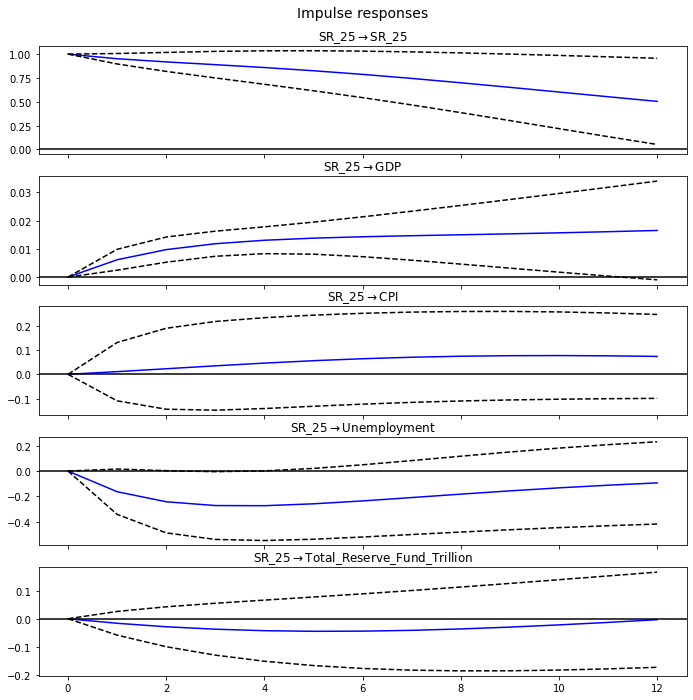

In [61]:
irf = results.irf(12)
irf_plot_SR = irf.plot(impulse='SR_25')

### factor_model_1.5 
### Replace shadow rate with EFFR
### EFFR: Level
### Factor: Level

In [62]:
factor_df_plot.rename(columns = {"Value":"EFFR"},inplace=True)
factor_df_plot = factor_df_plot[['EFFR','GDP','CPI','Unemployment','Total_Reserve_Fund_Trillion']]
factor_df_plot.head()

EFFR       GDP  CPI  Unemployment  Total_Reserve_Fund_Trillion
2006-04-30  4.79  1.374981  3.5           4.7                     0.875450
2006-07-31  5.24  1.386747  4.1           4.7                     0.874020
2006-10-31  5.25  1.403723  1.3           4.4                     0.885665
2007-01-31  5.25  1.420857  2.1           4.6                     0.884757
2007-04-30  5.25  1.438236  2.6           4.5                     0.912411

In [63]:
factor_effr_1 = factor_df_plot.copy()
X = sm.add_constant(factor_effr_1.iloc[:,1:-1])
result = sm.OLS(factor_effr_1['EFFR'],X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   EFFR   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     20.59
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           5.02e-09
Time:                        15:33:53   Log-Likelihood:                -89.896
No. Observations:                  58   AIC:                             187.8
Df Residuals:                      54   BIC:                             196.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.9284      1.629      5.481   

In [64]:
model = VAR(factor_effr_1)
model.select_order(5)
results = model.fit(maxlags=5, ic='bic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Nov, 2020
Time:                     15:33:54
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -12.7676
Nobs:                     57.0000    HQIC:                  -13.4250
Log likelihood:           20.1254    FPE:                9.76791e-07
AIC:                     -13.8429    Det(Omega_mle):     5.92206e-07
--------------------------------------------------------------------
Results for equation EFFR
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  1.143667         0.816576            1.401           0.161
L1.EFFR                                1.039614         0.050043           20.774          

In [65]:
pd.DataFrame(results.resid_corr,columns = factor_df_plot.columns, index =  factor_df_plot.columns)

EFFR       GDP       CPI  Unemployment  \
EFFR                         1.000000  0.491270  0.245719     -0.487661   
GDP                          0.491270  1.000000  0.349771     -0.931317   
CPI                          0.245719  0.349771  1.000000     -0.362880   
Unemployment                -0.487661 -0.931317 -0.362880      1.000000   
Total_Reserve_Fund_Trillion -0.579994 -0.836911 -0.237844      0.839426   

                             Total_Reserve_Fund_Trillion  
EFFR                                           -0.579994  
GDP                                            -0.836911  
CPI                                            -0.237844  
Unemployment                                    0.839426  
Total_Reserve_Fund_Trillion                     1.000000

### Null hypothesis is that there is no Granger-causality for the indicated variables.

In [67]:
print('EFFR -> GDP')
display(results.test_causality('GDP', ['EFFR'], kind='wald').summary())
print('EFFR -> CPI')
display(results.test_causality('CPI', ['EFFR'], kind='wald').summary())
print('EFFR -> Unemployment')
display(results.test_causality('Unemployment',['EFFR'], kind='wald').summary())
print('EFFR -> QE')
display(results.test_causality('Total_Reserve_Fund_Trillion',['EFFR'], kind='wald').summary())

EFFR -> GDP


<class 'statsmodels.iolib.table.SimpleTable'>

EFFR -> CPI


<class 'statsmodels.iolib.table.SimpleTable'>

EFFR -> Unemployment


<class 'statsmodels.iolib.table.SimpleTable'>

EFFR -> QE


<class 'statsmodels.iolib.table.SimpleTable'>

In [68]:
print('GDP -> EFFR')
display(results.test_causality('EFFR', ['GDP'], kind='wald').summary())
print('CPI -> EFFR')
display(results.test_causality('EFFR', ['CPI'], kind='wald').summary())
print('Unemployment -> EFFR')
display(results.test_causality('EFFR',['Unemployment'], kind='wald').summary())
print('QE -> EFFR')
display(results.test_causality('EFFR',['Total_Reserve_Fund_Trillion'], kind='wald').summary())

GDP -> EFFR


<class 'statsmodels.iolib.table.SimpleTable'>

CPI -> EFFR


<class 'statsmodels.iolib.table.SimpleTable'>

Unemployment -> EFFR


<class 'statsmodels.iolib.table.SimpleTable'>

QE -> EFFR


<class 'statsmodels.iolib.table.SimpleTable'>

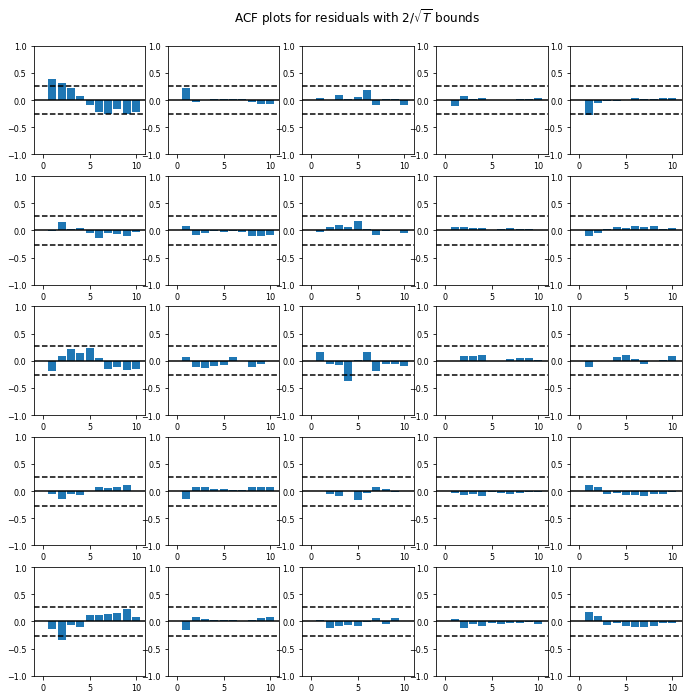

In [69]:
ACF_plot = results.plot_acorr()

In [70]:
lag_order = results.k_ar
print(lag_order)

1


<Figure size 1296x360 with 0 Axes>

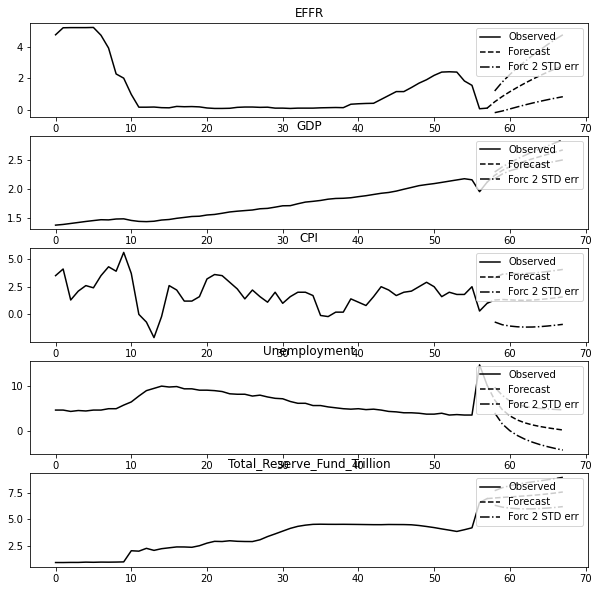

In [71]:
plt.figure(figsize=(18,5))
forcast_plot = results.plot_forecast(10)
plt.show()

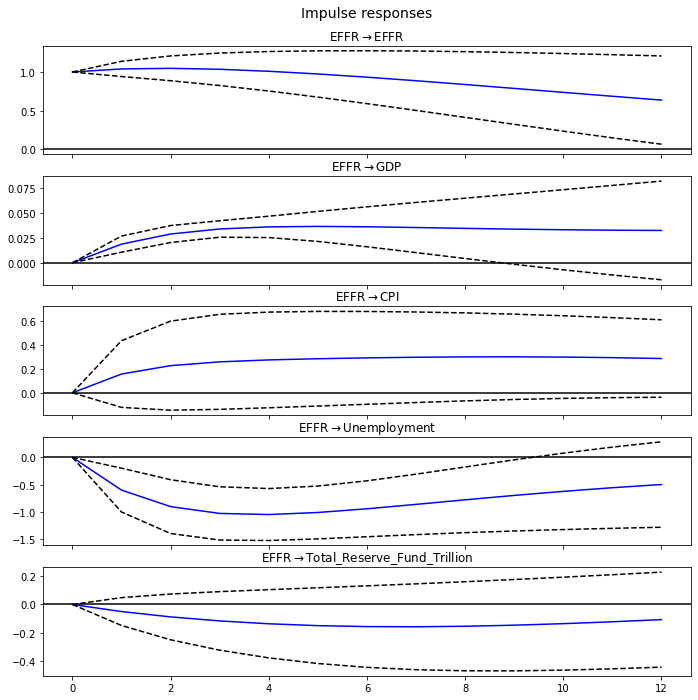

In [72]:
irf = results.irf(12)
irf_plot_SR = irf.plot(impulse='EFFR')

### factor_model_2
### Shadow rate: 1st difference
### Factor: Take 1st difference

In [73]:
factor_model_2 = factor_df.copy()
factor_model_2 = factor_df.diff()
factor_model_2.dropna(inplace=True)
factor_model_2 = factor_model_2.astype(float)
factor_model_2.head()

SR_25       GDP  CPI  Unemployment  Total_Reserve_Fund_Trillion
2006-07-31  0.405102  0.011766  0.6           0.0                    -0.001430
2006-10-31  0.006219  0.016976 -2.8          -0.3                     0.011645
2007-01-31  0.015161  0.017134  0.8           0.2                    -0.000908
2007-04-30 -0.007938  0.017379  0.5          -0.1                     0.027654
2007-07-31 -0.196149  0.015264 -0.2           0.2                    -0.014831

In [74]:
X = sm.add_constant(factor_model_2.iloc[:,1:])
result = sm.OLS(factor_model_2['SR_25'],X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  SR_25   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.817
Date:                Mon, 16 Nov 2020   Prob (F-statistic):             0.0343
Time:                        15:34:08   Log-Likelihood:                -44.818
No. Observations:                  57   AIC:                             99.64
Df Residuals:                      52   BIC:                             109.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [75]:
model = VAR(factor_model_2)
model.select_order(5)
results = model.fit(maxlags=5, ic='bic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Nov, 2020
Time:                     15:34:08
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -11.9462
Nobs:                     56.0000    HQIC:                  -12.6106
Log likelihood:          -2.42786    FPE:                2.19985e-06
AIC:                     -13.0312    Det(Omega_mle):     1.32244e-06
--------------------------------------------------------------------
Results for equation SR_25
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.166553         0.139716           -1.192           0.233
L1.SR_25                               0.508677         0.132994            3.825         

### factor_model_3
### Shadow rate: Level
### Factor: Take 1st difference

In [76]:
factor_model_3 = factor_df.copy()
factor_model_3.iloc[:,1:] = factor_df.iloc[:,1:].diff()
factor_model_3.dropna(inplace=True)
factor_model_3 = factor_model_3.astype(float)
factor_model_3.head()

SR_25       GDP  CPI  Unemployment  Total_Reserve_Fund_Trillion
2006-07-31  5.203065  0.011766  0.6           0.0                    -0.001430
2006-10-31  5.209284  0.016976 -2.8          -0.3                     0.011645
2007-01-31  5.224445  0.017134  0.8           0.2                    -0.000908
2007-04-30  5.216507  0.017379  0.5          -0.1                     0.027654
2007-07-31  5.020358  0.015264 -0.2           0.2                    -0.014831

In [77]:
X = sm.add_constant(factor_model_3.iloc[:,1:])
result = sm.OLS(factor_model_3['SR_25'],X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  SR_25   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.325
Date:                Mon, 16 Nov 2020   Prob (F-statistic):              0.273
Time:                        15:34:10   Log-Likelihood:                -144.57
No. Observations:                  57   AIC:                             299.1
Df Residuals:                      52   BIC:                             309.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [78]:
model = VAR(factor_model_3)
model.select_order(5)
results = model.fit(maxlags=5, ic='bic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Nov, 2020
Time:                     15:34:11
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -11.7528
Nobs:                     56.0000    HQIC:                  -12.4172
Log likelihood:          -7.84364    FPE:                2.66929e-06
AIC:                     -12.8378    Det(Omega_mle):     1.60464e-06
--------------------------------------------------------------------
Results for equation SR_25
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.294181         0.148715           -1.978           0.048
L1.SR_25                               0.949549         0.024635           38.545         

### The 1st model is considered to be optimal based on BIC and most variables are significant. So we use the level data for all factors instead of taking difference. 

### Test different split date for trainning and testing date

In [81]:
split_date = "201801"
train_df = forward_df[forward_df.index<split_date]
test_df = forward_df[forward_df.index>=split_date]

In [82]:
parameters_25_split = pd.read_excel("ZLB_split_18.xlsx").iloc[:,1].values
parameters_25_split_df = pd.DataFrame(parameters_25_split)

In [83]:
dateList1 = train_df.index
dateList1 = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in dateList1]
SR_train = EFK_SRTSM(nparam,maturities,train_df.values,1)
Xf_train = EFK_SRTSM(nparam,maturities,train_df.values,2)

In [84]:
rhoP = parameters[0:9];
rhoP = np.reshape(rhoP, [3,3], order='F')
muP = parameters[9:12]
rhoQ1 = parameters[12]; rhoQ2 = parameters[13];
rhoQ = np.zeros((3, 3)); np.fill_diagonal(rhoQ, [rhoQ1, rhoQ2, rhoQ2])
rhoQ[1, 2] = 1
sigma = [[abs(parameters[14]), 0, 0],
        [parameters[15], abs(parameters[17]), 0],
        [parameters[16], parameters[18], abs(parameters[19])]]
delta0 = parameters[20]
sqrt_omega = parameters[21]

In [85]:
Xf_test = [Xf_train[:,-1]]
for i in range(len(test_df)):
    Xf_t = muP + np.dot(rhoP,Xf_test[-1])
    Xf_test.append(Xf_t)

Xf_test = Xf_test[1:]
Xf_test = np.array(Xf_test)
SR_test = Xf_test.dot(np.array([1,1,0])) + delta0

We assume we stand on 2018 and don't have information on the future treasury yield. The predict of shadow rate based on VAR(1) model is shown as below.

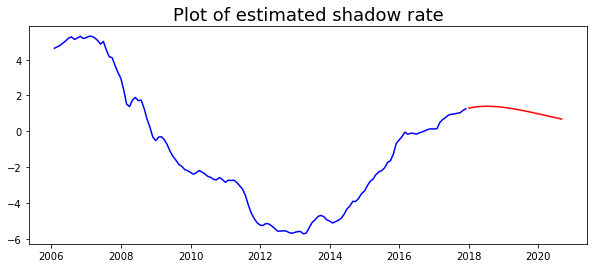

In [90]:
plt.figure(figsize=(10,4))
dateList_train = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in train_df.index]
dateList_test = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in test_df.index]

plt.plot(dateList_train, SR_train, 'b')
plt.plot(dateList_test, SR_test, 'r')
plt.title('Plot of estimated shadow rate', fontsize = 18)
plt.show()

We assume we have the treasury yield information from 2006 and 2020. While we fit the SRTSM model with treasury yield before 2018 and plot the shadow rate for the whole sample period.

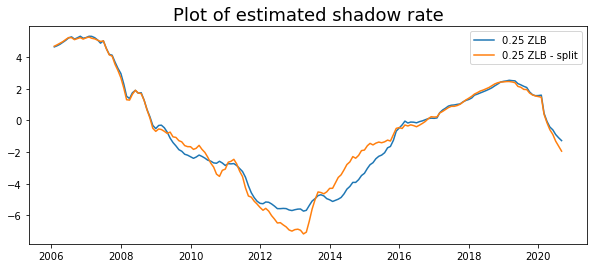

In [91]:
nparam_25_split = parse_param(parameters_25_split, 0.25)
SR_25_split = EFK_SRTSM(nparam_25_split,maturities,forwardrates,1)

plt.figure(figsize=(10,4))
plt.plot(dateList, SR, label = '0.25 ZLB')
plt.plot(dateList, SR_25_split, label = '0.25 ZLB - split')
plt.title('Plot of estimated shadow rate', fontsize = 18)
plt.legend()
plt.show()

## Fit to Japan treasury yield

In [92]:
symbol = "MOFJ/INTEREST_RATE_JAPAN"  
df_JP = web.DataReader(symbol, 'quandl', 
                               start='2006-01-01', 
                               end='2020-09-01')
df_JP.drop(['40Y'],axis=1,inplace=True)

In [93]:
# convert into monthly data (use the first observation)
df_JP["month"] = [dt.datetime.strftime(x,"%Y%m") for x in df_JP.index]
df_JP_M = df_JP.groupby("month").mean()

1Y        2Y        3Y        4Y        5Y        6Y        7Y  \
month                                                                          
200601  0.082632  0.264789  0.457947  0.660053  0.834737  0.994105  1.149789   
200602  0.133300  0.379000  0.611150  0.834950  1.017700  1.180400  1.327650   
200603  0.236682  0.546682  0.783955  1.006136  1.179455  1.334455  1.474409   
200604  0.312950  0.649150  0.931850  1.174850  1.370650  1.533900  1.681750   
200605  0.424000  0.760750  1.011650  1.231500  1.407750  1.559350  1.692550   

              8Y        9Y       10Y       15Y       20Y       25Y       30Y  
month                                                                         
200601  1.283842  1.386526  1.463526  1.736947  1.990842  2.205947  2.324737  
200602  1.443350  1.519100  1.564000  1.816200  2.012950  2.168600  2.277750  
200603  1.579364  1.646182  1.677091  1.880500  2.042318  2.194091  2.269273  
200604  1.792100  1.865750  1.893250  2.098850  2.238850  2.393400  2.463000  
200605  1.799050  1.880150  1.909850  2.113050  2.227900  2.376350  2.423200

1Y        2Y        3Y        4Y        5Y        6Y        7Y  \
month                                                                          
202005 -0.174667 -0.167778 -0.171444 -0.153000 -0.127833 -0.130722 -0.122778   
202006 -0.168909 -0.158591 -0.153818 -0.134045 -0.107318 -0.108909 -0.097364   
202007 -0.169000 -0.140143 -0.151905 -0.135762 -0.109571 -0.112810 -0.108714   
202008 -0.129850 -0.120450 -0.124500 -0.119700 -0.089200 -0.093000 -0.085450   
202009 -0.130000 -0.120000 -0.113000 -0.106000 -0.076000 -0.078000 -0.066000   

              8Y        9Y       10Y       15Y       20Y       25Y       30Y  
month                                                                         
202005 -0.096556 -0.045833  0.002500  0.214667  0.336444  0.418167  0.460333  
202006 -0.069591 -0.019500  0.025409  0.245909  0.387091  0.476864  0.542136  
202007 -0.077048 -0.024619  0.025381  0.255762  0.417952  0.511857  0.582238  
202008 -0.052900 -0.007050  0.038300  0.269300  0.414000  0.505800  0.589550  
202009 -0.031000  0.008000  0.051000  0.288000  0.425000  0.518000  0.611000

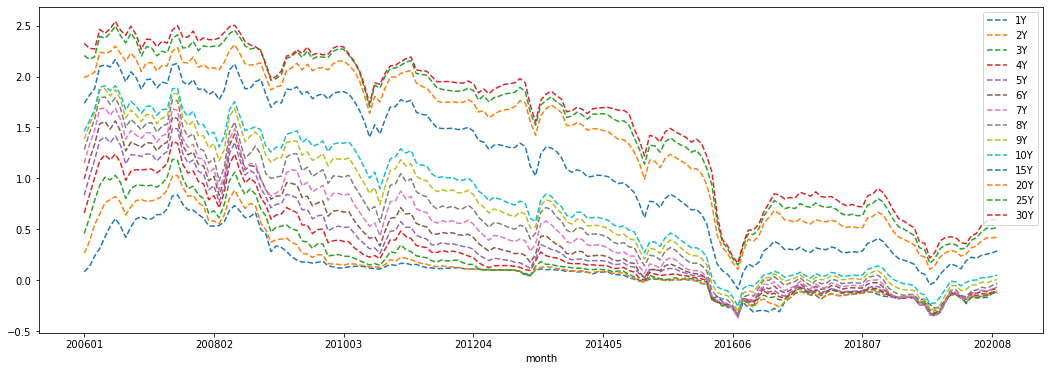

In [94]:
df_JP_M.plot(figsize = (18,6),ls='--')
display(df_JP_M.head(),df_JP_M.tail())
plt.show()

In [95]:
maturities_JP = np.array([12, 24, 36, 48 , 60, 72 , 84, 96, 108, 120, 180, 240, 300, 360])/12
maturities_diff_JP = np.diff(maturities_JP)
T,n = df_JP_M.shape

In [96]:
forward_rate_JP = df_JP_M.values[:,:-1]  + (maturities_JP[1:] * (np.diff(df_JP_M,axis=1)/maturities_diff_JP))
forward_rate_JP = np.c_[df_JP_M.values[:,0],forward_rate_JP]

In [97]:
cols = ["f"+str(maturities_JP[i])+","+str(maturities_JP[i+1]) for i in range(n-1)]
cols.insert(0,'f0,1')
forward_JP_df = pd.DataFrame(forward_rate_JP,columns=cols,index=df_JP_M.index)
#forward_df.to_excel("forward_df.xlsx")

In [98]:
maturities_JP = np.array([1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 15., 20., 25., 30.])
maturities_JP = np.array(maturities_JP)*12
maturities_JP = np.array(maturities_JP, dtype=int)

### JPY ZLB = -0.25

In [99]:
parameters_25_JP = pd.read_excel("trial_25_JPY.xlsx").iloc[:,1].values
parameters_25_JP_df = pd.DataFrame(parameters_25_JP)

In [100]:
dateList_25_JP = forward_JP_df.index
dateList_25_JP = [dt.datetime(int(x[:4]), int(x[4:]), 1) for x in dateList_25_JP]

In [101]:
nparam_JP = parse_param(parameters_25_JP, -0.25)
SR_JP_25 = EFK_SRTSM(nparam_JP,maturities_JP,forward_rate_JP,1)

### JPY ZLB = -0.1

In [102]:
parameters_10_JP = pd.read_excel("trial_10_JPY.xlsx").iloc[:,1].values
parameters_10_JP_df = pd.DataFrame(parameters_10_JP)

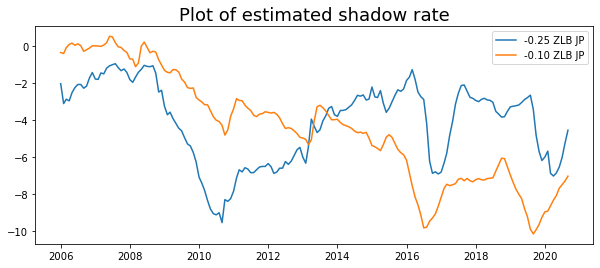

In [103]:
nparam_JP = parse_param(parameters_10_JP, -0.1)
SR_JP_10 = EFK_SRTSM(nparam_JP,maturities_JP,forward_rate_JP,1)

plt.figure(figsize=(10,4))
plt.plot(dateList_25_JP, SR_JP_25, label = '-0.25 ZLB JP')
plt.plot(dateList_25_JP, SR_JP_10, label = '-0.10 ZLB JP')
plt.title('Plot of estimated shadow rate', fontsize = 18)
plt.legend()
plt.show()

The model is more sensitive to the lower bond for the Japan market, as the estiamted shadow rate shows divergence.

## Fit the UK treasury yield

The data is available from https://www.bankofengland.co.uk/statistics/yield-curves

In [104]:
forward_df = pd.read_excel("data/UK_fwd_monthly_cleaned.xlsx")
forward_df.set_index("Date", inplace=True)
forward_df.index = [x.strftime("%Y%m") for x in forward_df.index]
forward_df = forward_df[forward_df.index>="200601"]

In [105]:
maturities = [1,2,3,4,5,6,7,10,15,20,25]
forward_df = forward_df.loc[:,maturities].copy()

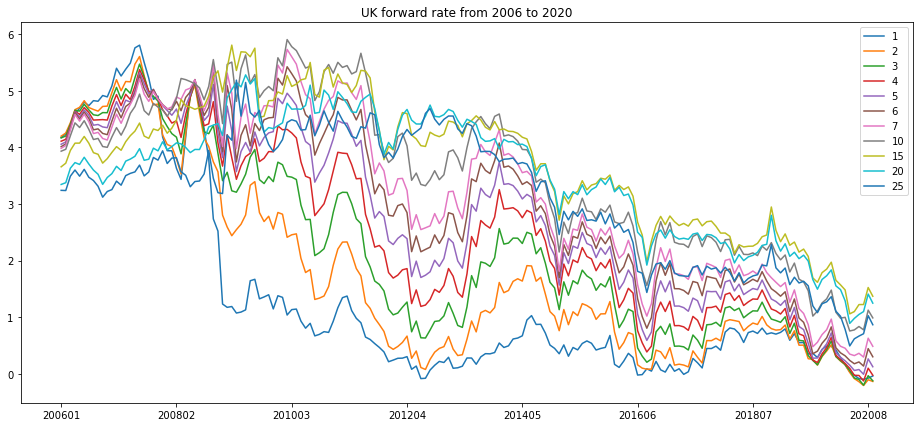

In [107]:
forward_df.plot(figsize=(16,7))
plt.title('UK forward rate from 2006 to 2020')
plt.show()

In [110]:
parameters = pd.read_csv("trial_00_UK_br.csv").iloc[:,1].values
startv = parameters
epsilon = 1e3 

In [111]:
maturities = [1,2,3,4,5,6,7,10,15,20,25]
maturities = np.array(maturities)*12
maturities = np.array(maturities, dtype=int)
forwardrates = forward_df.values

In [122]:
def generate_UK_sensitivity (parameters,zlb):
    
    
    def decorated_cost(parameters):
        from EFK_SRTSM import EFK_SRTSM
        parameters = np.append(parameters, zlb)
        return EFK_SRTSM(parameters, maturities, forwardrates, 0)

    starttime = dt.datetime.now()
    xopt = fmin(decorated_cost, startv, maxiter= 1e6, full_output=True)
    parameters = xopt[0]
    nparam = np.append(parameters, zlb) # lower-bound

    print ("======== shadow rate term structure model========\n")
    print ("The log likelihood value is: ", EFK_SRTSM(nparam, maturities, forwardrates, 0))
    endtime = dt.datetime.now()
    print((endtime - starttime).seconds)
    
    #save parameters
    #pd.DataFrame(parameters).to_csv(path_or_buf = 'parameters\\trial_UK_br_'+str(zlb)+'.csv')
    
    datelist = [dt.datetime.strptime(x, '%Y%m') for x in forward_df.index]
    
    #calculate Shadow rate
    SR = EFK_SRTSM(nparam, np.array(maturities), forward_df.values, 1)
    
    
    #plot the Shadow rate
    plt.figure(figsize=(10,4))
    plt.plot(datelist, SR)
    plt.title('UK Shadow rate with lower bound as '+ str(zlb))
    plt.show()

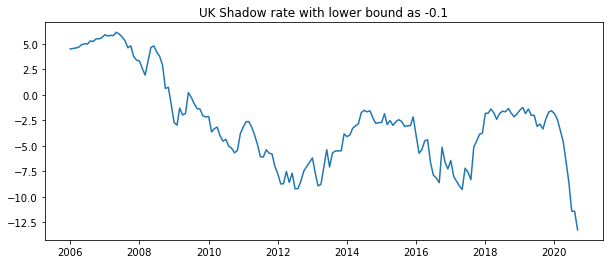

In [120]:
parm = pd.read_csv('parameters\\trial_UK_br_-0.1.csv',index_col = 0)
nparam = np.append(parameters, -0.1)
datelist = [dt.datetime.strptime(x, '%Y%m') for x in forward_df.index]

#calculate Shadow rate
SR = EFK_SRTSM(nparam, np.array(maturities), forward_df.values, 1)
#plot the Shadow rate
plt.figure(figsize=(10,4))
plt.plot(datelist, SR)
plt.title('UK Shadow rate with lower bound as '+ str(-0.1))
plt.show()

Optimization terminated successfully.
         Current function value: -713.721170
         Iterations: 8564
         Function evaluations: 10691
======== shadow rate term structure model========

The log likelihood value is:  -713.7211697740288
1071


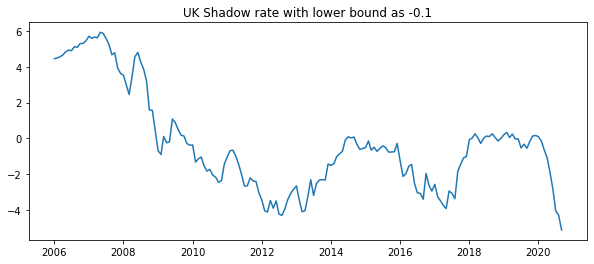

In [123]:
generate_UK_sensitivity(parameters,-0.1)

Optimization terminated successfully.
         Current function value: -716.501058
         Iterations: 13304
         Function evaluations: 16531
======== shadow rate term structure model========

The log likelihood value is: - -716.501058112913
1437


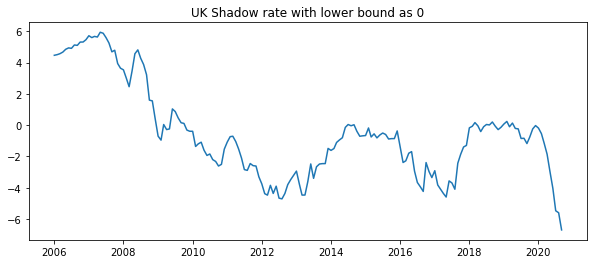

In [238]:
generate_UK_sensitivity(parameters,0)

Optimization terminated successfully.
         Current function value: -695.045963
         Iterations: 12225
         Function evaluations: 15250
======== shadow rate term structure model========

The log likelihood value is: - -695.0459628478463
1337


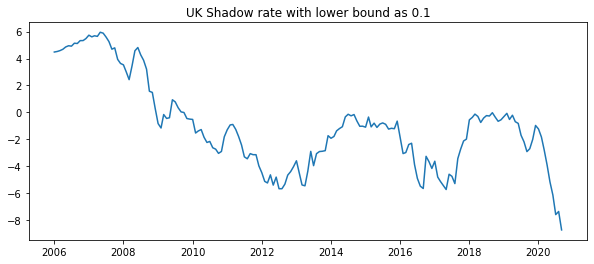

In [239]:
generate_UK_sensitivity(parameters,0.1)

Optimization terminated successfully.
         Current function value: -650.534708
         Iterations: 15022
         Function evaluations: 18681
======== shadow rate term structure model========

The log likelihood value is: - -650.5347078449377
1799


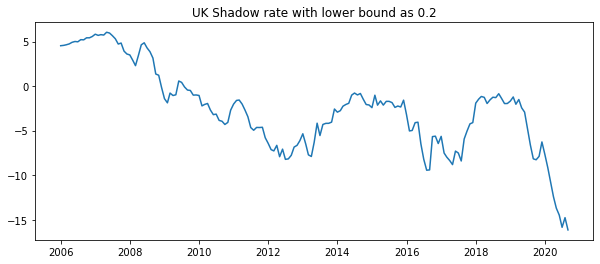

In [241]:
generate_UK_sensitivity(parameters,0.2)